# Finding Lane Lines Project
___

## Objective:
___

My Objective for this project is to find the Lane Lines in Images and Videos taken from a camera mounted on the center of a vehicle.

This will be completed by Thresholding Grayscale pixel values and using Canny Edge detection. Afterwards, I will mask the region of the edges detected to solely the region where lane lines would appear.

Then, next I will use a Hough Transformation on the masked edges to get the detected line segments, and calculate the lanes slopes to determine wheter the detected line is a part of the left lane or the right lane. 

Lastly I will calculate the y-intercept of the lane lines and draw the detected straight line on the image.

## Code:
___

In [44]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

import numpy as np
import cv2
import glob

%matplotlib inline

#### Here are some the images used to test how robust the Lane Finding Pipeline should be.

There are 6 Test Images


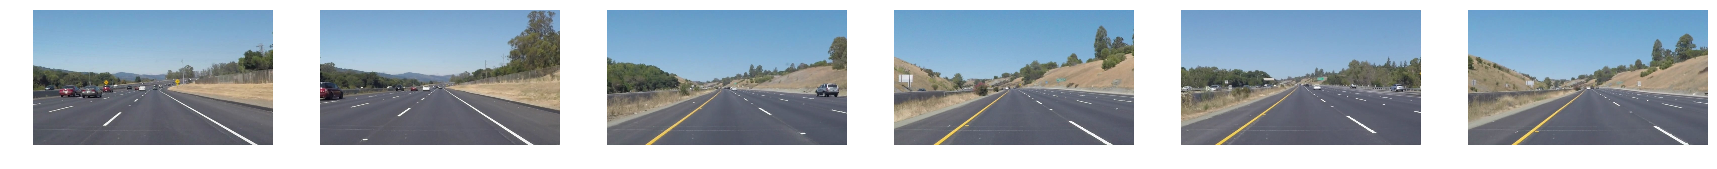

In [48]:
test_images = glob.glob('test_images/*.jpg')
num_images = len(test_images)
images = []
i = 0

fig = plt.figure(figsize=(30, 12)) 
gs = gridspec.GridSpec(1,num_images) 


for path in test_images:
    image = mpimg.imread(path)
    images.append(image)
    plt.subplot(gs[i])
    plt.imshow(image)
    plt.axis('off')
    i += 1

print('There are', len(images), 'Test Images')

### Create the pipeline for drawing the lane lines as a function

In [49]:
def process_image(image, display=False):
    
    # Convert the Image to Grayscale
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

    
    # Defined a kernel size and applied Gaussian smoothing
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

    
    # Thresholding Grayscale pixel values
    low_color_threshold = 165
    high_color_threshold = 255
    color_mask = cv2.inRange(blur_gray,low_color_threshold,high_color_threshold)
    color_masked = cv2.bitwise_and(blur_gray,blur_gray, mask=color_mask)


    # Used Canny Edge Detection to detect edges with the follwing parameters
    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(color_masked, low_threshold, high_threshold)
    
    
    # Mask the region of interest for lane lines
    mask = np.zeros_like(edges)
    ignore_mask_color = 255
    
    # Defined the 4 sided polygon that will represent our region of interest
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(475, 310), (465, 310), (imshape[1],imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    masked_edges = cv2.bitwise_and(edges, mask)
    
    
    # Here are the Hough transform parameters
    
    rho = 2 # distance resolution in pixels of the Hough grid (Or Hough Accumulator Array)
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    
    threshold = 25     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 3 # minimum number of pixels making up a line
    max_line_gap = 5    # maximum gap in pixels between connectable line segments

    # Detected line segments from the masked edges aquired earlier
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)

    # Iterate over each lne segment and draw their lines on a blank image
    leftSlopeTotal = 0
    rightSlopeTotal = 0
    leftYintTotal = 0
    rightYintTotal = 0
    leftAmount = 0
    rightAmount = 0

    for line in lines:
        for x1,y1,x2,y2 in line:

            if((x2-x1)==0):
                print('One of the values divides by 0')
            else:
                curSlope = (y2-y1)/(x2-x1)
                curYint1 = -1*curSlope*x1 + y1
                curYint2 = -1*curSlope*x2 + y2
                if(curSlope<=-0.5):
                    # Left Side
                    leftSlopeTotal = leftSlopeTotal + curSlope
                    leftYintTotal = leftYintTotal + curYint1
                    leftAmount = leftAmount + 1

                elif(curSlope>=0.5):
                    # Right Side
                    rightSlopeTotal = rightSlopeTotal + curSlope
                    rightYintTotal = rightYintTotal + curYint1
                    rightAmount= rightAmount + 1

    avgLeftSlope =leftSlopeTotal/leftAmount
    avgRightSlope = rightSlopeTotal/rightAmount
    avgLeftYint = leftYintTotal/leftAmount
    avgRightYint = rightYintTotal/rightAmount

    leftYpoint1 = imshape[0]
    leftXpoint1 = int((leftYpoint1-avgLeftYint)/avgLeftSlope)
    
    leftYpoint2 = 310
    leftXpoint2 = int((leftYpoint2-avgLeftYint)/avgLeftSlope)
    
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    cv2.line(line_image,(leftXpoint1,leftYpoint1),(leftXpoint2,leftYpoint2),(255,0,0),10) 

    rightYpoint1 = imshape[0]
    rightXpoint1 = int((rightYpoint1-avgRightYint)/avgRightSlope)

    rightYpoint2 = 310
    rightXpoint2 = int((rightYpoint2-avgRightYint)/avgRightSlope)
    cv2.line(line_image,(rightXpoint1,rightYpoint1),(rightXpoint2,rightYpoint2),(0,0,255),10) 


    # Create a "color" binary image to combine with line image
    # color_edges = np.dstack((masked_edges, masked_edges, masked_edges)) 

    # Draw the lines on the edge image
    output_image = cv2.addWeighted(image, 0.8, line_image, 1, 0)
    # lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0)
    
    
    
    if (display):
        fig = plt.figure(figsize=(30, 12)) 
        gs = gridspec.GridSpec(1,4) 

        plt.subplot(gs[0])
        plt.title('Grayscale Image')
        plt.imshow(gray, cmap='gray')
        plt.axis('off')
        
        plt.subplot(gs[1])
        plt.title('Region of Interest Mask')
        plt.imshow(mask, cmap='gray')
        plt.axis('off')
        
        plt.subplot(gs[2])
        plt.title('Edges within the Region of Interest')
        plt.imshow(masked_edges, cmap='gray')
        plt.axis('off')
        
        plt.subplot(gs[3])
        plt.title('Output Image')
        plt.imshow(output_image)
        plt.axis('off')


    return output_image


### Here are some images of each step in the pipeline

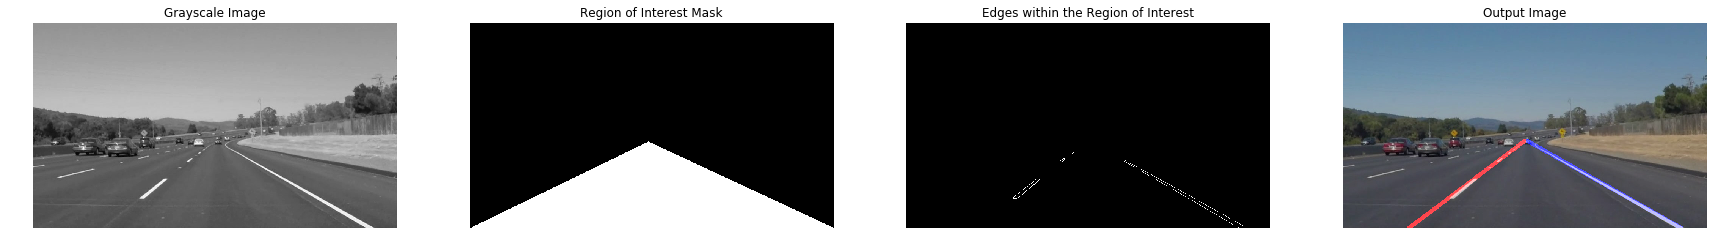

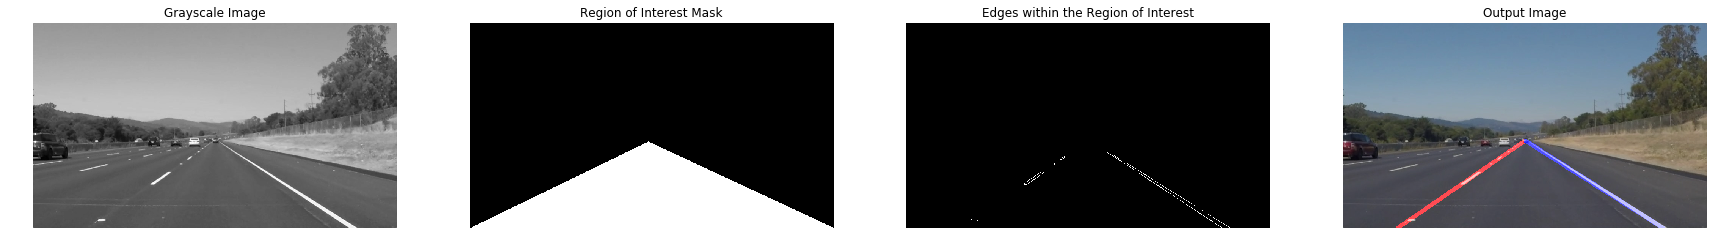

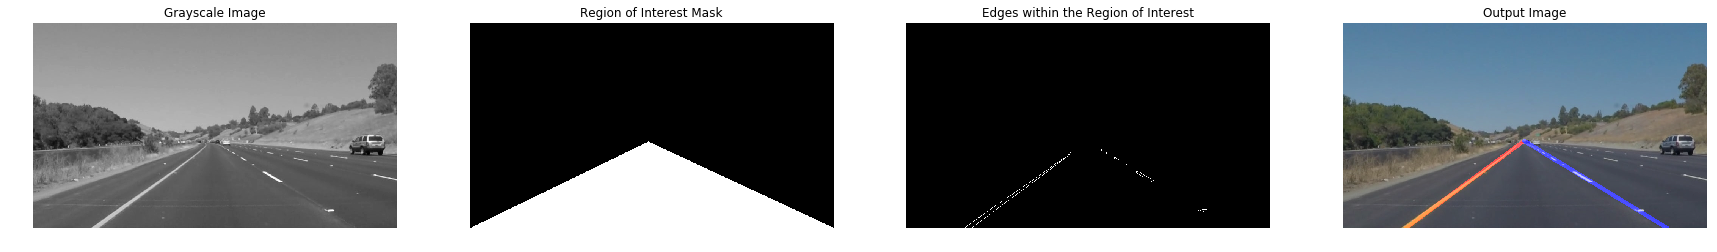

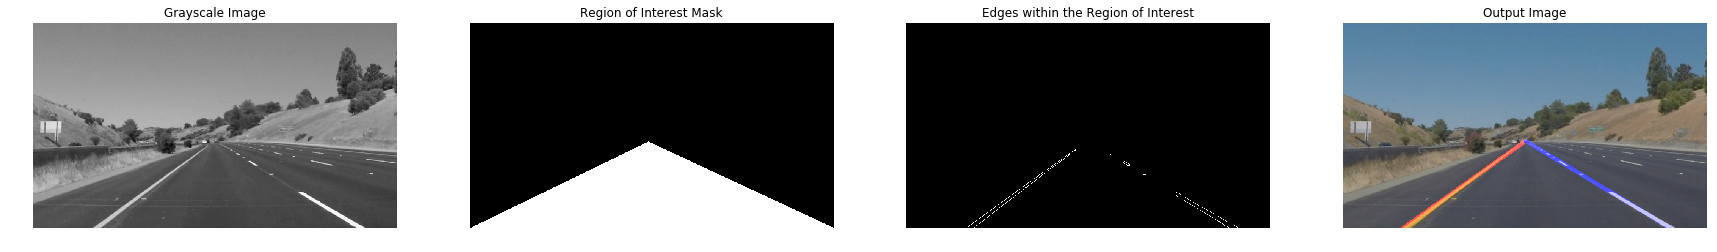

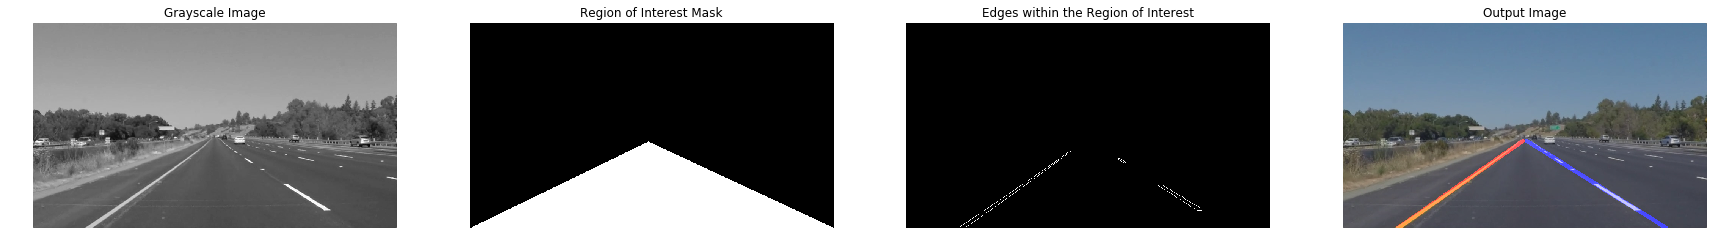

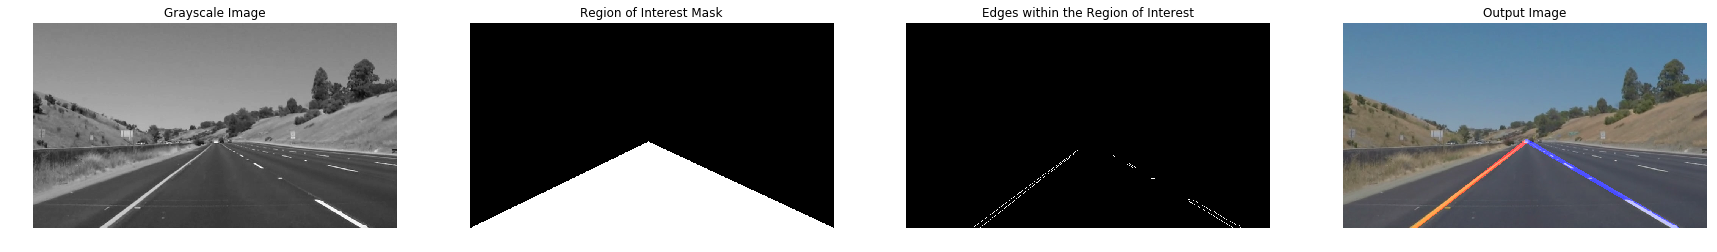

In [51]:
for image in images:
    process_image(image,display=True)

## Video Output
___
Here is the pipeline computing lane lines for every frame in a video. The pipeline was tested on 2 videos, solidWhiteRight.mp4, and solidYellowLeft.mp4

In [57]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_video(path):
    
    filename = path.split('.')[0]
    
    video_output = filename + '_output.mp4'
    clip1 = VideoFileClip(path)
    white_clip = clip1.fl_image(process_image)
    white_clip.write_videofile(video_output, audio=False)

inputVideo1 = 'solidYellowLeft.mp4'

process_video(inputVideo1)

from IPython.display import HTML

HTML("""
<video width="320" height="240" controls>
  <source src="solidYellowLeft_output.mp4" type="video/mp4">
</video>
""")

[MoviePy] >>>> Building video solidYellowLeft_output.mp4
[MoviePy] Writing video solidYellowLeft_output.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:28<00:00, 23.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: solidYellowLeft_output.mp4 



In [58]:

inputVideo2 = 'solidWhiteRight.mp4'
process_video(inputVideo2)

HTML("""
<video width="320" height="240" controls>
  <source src="solidWhiteRight_output.mp4" type="video/mp4">
</video>
""")

[MoviePy] >>>> Building video solidWhiteRight_output.mp4
[MoviePy] Writing video solidWhiteRight_output.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:08<00:00, 24.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: solidWhiteRight_output.mp4 



## Conclusion:
___

The pipeline works well for these specific videos, but will not perform well if the conditions like road color change.

In order to make a more Robust pipeline for detecting lanes, other color spaces need to be used.

